# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

#### DATA URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import zipfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import pandas as pd
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import random
import warnings
from skimage.color import rgb2yuv
import tensorflow as tf

from pandas.io.parsers import read_csv
from skimage import io


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
#url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, 
                   baseUrl='https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/',
                   outDir= 'data/',
                   force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(outDir+filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(baseUrl + filename, outDir+filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  else:
    filename = outDir+filename
    print('\nFile already present!')
  statinfo = os.stat(filename)
  return filename

zipFile = maybe_download('traffic-signs-data.zip')


File already present!


In [3]:
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    zip_ref = zipfile.ZipFile(zipFile, 'r')
    zip_ref.extractall(root)
    zip_ref.close()
  data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))]
  print(data_folders)
  return data_folders
  
folders = maybe_extract(zipFile)

data/traffic-signs-data already present - Skipping extraction of data/traffic-signs-data.zip.
['data/traffic-signs-data\\test.p', 'data/traffic-signs-data\\train.p', 'data/traffic-signs-data\\valid.p']


In [4]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = folders[1]
validation_file=folders[2]
testing_file = folders[0]

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [6]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.bincount(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [7]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

#### Frequency Distribution

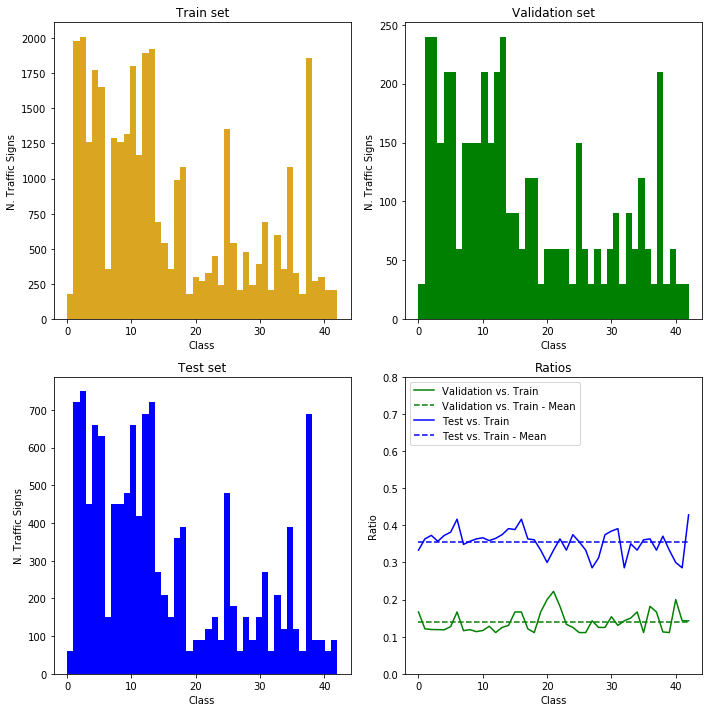

In [8]:
#fig, axes = plt.subplots(nrows=2, ncols=2)
fig, axes = plt.subplots(nrows=2 , ncols=2, figsize=(10, 10))
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist(y_train, label='class', bins=43 , color='goldenrod')
ax0.legend(prop={'size': 10})
ax0.legend_.remove()
ax0.set_title('Train set')
ax0.set_xlabel("Class")
ax0.set_ylabel("N. Traffic Signs")

ax1.hist(y_valid, label='class', bins=43 , color='green')
ax1.legend(prop={'size': 10})
ax1.set_title('Validation set')
ax1.legend_.remove()
ax1.set_xlabel("Class")
ax1.set_ylabel("N. Traffic Signs")

ax2.hist(y_test, label='class', bins=43 , color='blue')
ax2.legend(prop={'size': 10})
ax2.set_title('Test set')
ax2.legend_.remove()
ax2.set_xlabel("Class")
ax2.set_ylabel("N. Traffic Signs")

# Ratios 
val2tr = np.zeros(43)
te2tr = np.zeros(43)

for i in range(43):
    val2tr[i] = np.sum(y_valid==i)/np.sum(y_train==i)
    te2tr[i] = np.sum(y_test==i)/np.sum(y_train==i)

ax3.plot(np.arange(43), val2tr , color='green' , label='Validation vs. Train')
ax3.plot(np.arange(43), val2tr.mean()*np.ones(43) , color='green' , label='Validation vs. Train - Mean' , linestyle='--')
ax3.plot(np.arange(43), te2tr , color='blue' , label='Test vs. Train')
ax3.plot(np.arange(43), te2tr.mean()*np.ones(43) , color='blue' , label='Test vs. Train - Mean',linestyle='--')
ax3.legend(loc='upper left')
ax3.set_xlabel("Class")
ax3.set_ylim([0, 0.8])
ax3.set_ylabel("Ratio")
ax3.set_title('Ratios')

fig.tight_layout()
plt.show()

In [9]:
print("*** Validation vs. Train ***")
print("Mean:",val2tr.mean()," - STD:",val2tr.std())

*** Validation vs. Train ***
Mean: 0.140056969189  - STD: 0.0282026402946


In [10]:
print("*** Test vs. Train ***")
print("Mean:",te2tr.mean()," - STD:",te2tr.std())

*** Test vs. Train ***
Mean: 0.35531432745  - STD: 0.0331591700575


#### Checking for unblanced classes 

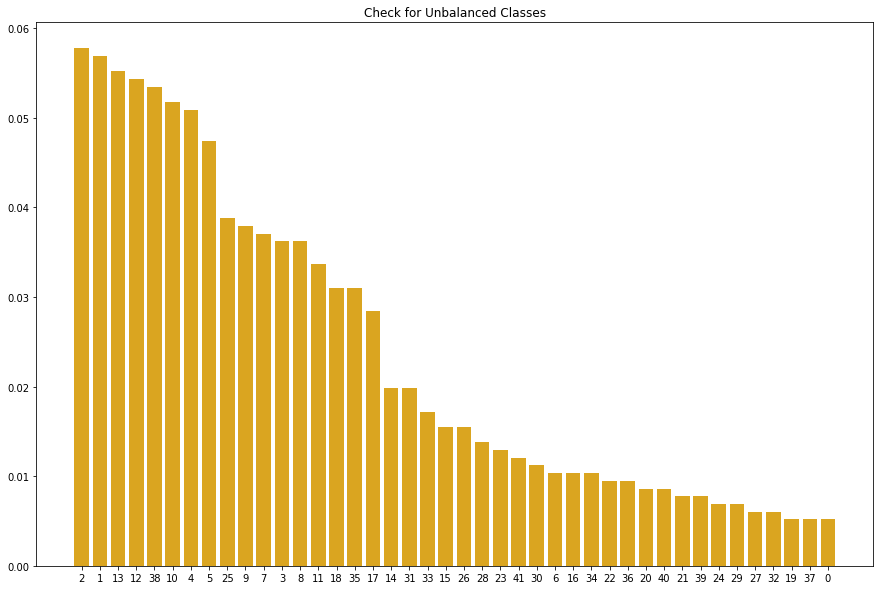

In [11]:
# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Check for Unbalanced Classes")
freq, classes = np.histogram(y_train , bins=42 , normed=True)
indices = np.argsort(freq )[::-1]
plt.bar(range(42), freq[indices], color="goldenrod", align="center" )
plt.xticks(range(42), indices)
plt.show()

In [12]:
ct = pd.DataFrame({'Class': indices, '% Train Observations': freq[indices]*100 } )
ct = ct.set_index(['Class'])
ct

,% Train Observations
Class,
2,5.776028
1,5.689819
13,5.517400
12,5.431191
38,5.344981
10,5.172562
4,5.086353
5,4.741516
25,3.879422


We can see clearly there are classes like 2 and 1 with 5.7% of training set vs. classes like 37 and 0 with 0.51% of training set.       

#### Plot Signal Images 

Sample train images: 100%|█████████████████████████████████████████████████████████| 43/43 [00:11<00:00,  3.76labels/s]


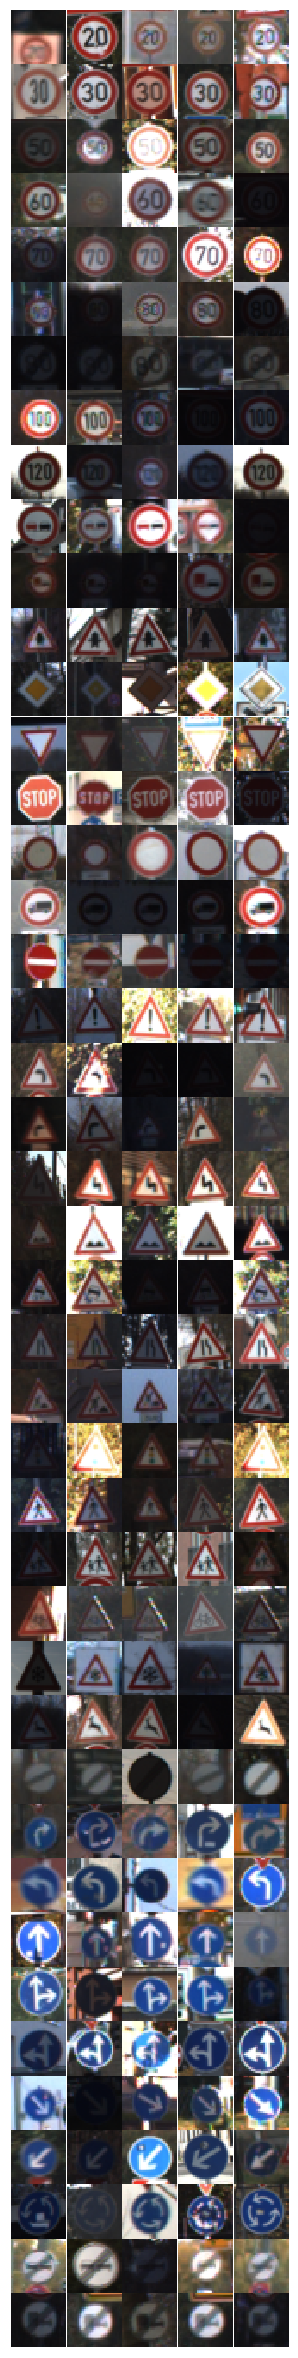

In [13]:
sample_size = 5 #five image per class label
n_labels = n_classes
count = 0 #book keeping for plots
fig = plt.figure(figsize=(sample_size, n_labels))
grid = gridspec.GridSpec(n_labels, sample_size, wspace=0.0, hspace=0.0)
labelset_pbar = tqdm(range(n_labels), desc='Sample train images', unit='labels')
for i in labelset_pbar:
    ind = y_train == i
    subset_x =X_train [ind,] #get all images that belong to class i
    for x in range(sample_size):
        img = random.choice(subset_x) #randomly pick on image from class i
        ax = plt.Subplot(fig, grid[count])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
        fig.add_subplot(ax)
        count +=1

    # hide the borders
    if i == (n_labels-1):
        all_axes = fig.get_axes()
        for ax in all_axes:
            for sp in ax.spines.values():
                sp.set_visible(False)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### Conversion to YUV space

After normalization, as shown in [P. Sermanet, Y. LeCun, Traffic Sign Recognition with Multi-Scale Convolutional Networks Proceedings of International Joint Conference on Neural Networks (IJCNN'11), 2011](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), all 32x32 images are converted to YUV space. 

In [14]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def normalized_image(image_data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return np.array([rgb2yuv(image) for image in tqdm(image_data)])


print('Normalizing Training Images...')
X_train_norm = (X_train - 128.0)/128.0
X_train_norm = normalized_image(X_train_norm)

print('\nNormalizing Validation Images...')
X_valid_norm = (X_valid - 128.0)/128.0
X_valid_norm = normalized_image(X_valid_norm)

print('\nNormalizing Test Images...')
X_test_norm = (X_test - 128.0)/128.0
X_test_norm = normalized_image(X_test_norm)

Normalizing Training Images...


100%|██████████████████████████████████████████████████████████████████████████| 34799/34799 [00:05<00:00, 6398.25it/s]



Normalizing Validation Images...


100%|████████████████████████████████████████████████████████████████████████████| 4410/4410 [00:00<00:00, 7258.55it/s]



Normalizing Test Images...


100%|██████████████████████████████████████████████████████████████████████████| 12630/12630 [00:01<00:00, 6807.13it/s]


In [15]:
#assert  X_train_norm[110][1,1,0] == (X_train[110][1,1,0] - 128.0)/128.0
X_train[110][1,1,0] , X_train_norm[110][1,1,0]

(41, -0.69255468749999993)

### Model Architecture

I started with the LeNet-5 solution from the lecture and here are the main nimprovments:

* __Local response normalization__ after activation functions of each convolutional layer; for further information see [A. Krizhevsky, I. Sutskever, G. E. Hinton, ImageNet Classification with Deep Convolutional Neural Networks, Advances in Neural Information Processing Systems 25 (NIPS 2012)](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks)
* __Max pooling strides__ [1,1,1,1] instead of [1,2,2,1]
* __Multi-Scale Features__, i.e. as shown in [P. Sermanet, Y. LeCun, Traffic Sign Recognition with Multi-Scale Convolutional Networks Proceedings of International Joint Conference on Neural Networks (IJCNN'11), 2011](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) the output of the first stage is branched out and fed to the classifier, in addition to the output of the second stage
* __Dropout__, only during training with holding probabilities set to 0.5 
* __Fully connected classifier__ with number of hidden units 12118x800 (input), 800x84 (hidden), 84x43 (output) 



In [16]:
from tensorflow.contrib.layers import flatten
    


def LeNet_MS(x,dropout):    
     # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W      = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b      = tf.Variable(tf.zeros(6))
    conv1_before = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID' , name='conv_1') + conv1_b
    conv1        = tf.nn.relu(conv1_before)
    #lrn2
    radius       = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
    conv1        = tf.nn.local_response_normalization(conv1,depth_radius=radius,alpha=alpha,beta=beta,bias=bias)
    # Pooling
    conv1        = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')


    # Layer 2: Convolutional
    conv2_W        = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b        = tf.Variable(tf.zeros(16))
    conv2_before   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID' , name='conv_2') + conv2_b
    conv2          = tf.nn.relu(conv2_before)
    conv2          = tf.nn.local_response_normalization(conv2,depth_radius=radius,alpha=alpha,beta=beta,bias=bias)
    # Pooling 
    conv2          = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')


    # Flatten
    #fc0   = flatten(conv2)
    fc0 = tf.concat(1,[flatten(conv2), flatten(conv1)])
    print(fc0.get_shape().as_list())  
 
    # Layer 3: Fully Connected
    fc1_W = tf.Variable(tf.truncated_normal(shape=(12118, 800), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(800))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1   = tf.nn.relu(fc1)
    fc1   = tf.cond(dropout > 0,lambda: tf.nn.dropout(fc1, dropout), lambda: fc1)

    # Layer 3: Fully Connected
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(800, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.cond(dropout > 0,lambda: tf.nn.dropout(fc2, dropout), lambda: fc2)


    # Layer 5: Fully Connected
    fc6_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc6_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc6_W) + fc6_b
    
    return logits , conv1_before , conv2_before

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [17]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle

EPOCHS = 30
BATCH_SIZE = 128

dropout = tf.placeholder(tf.float32, shape=())
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
rate = 0.001
logits , conv1_before , conv2_before = LeNet_MS(x,dropout)
#tf.summary.histogram( "logits_graph", logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y , dropout: 0.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

[None, 12118]


In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_sh, y_train_sh = shuffle(X_train_norm, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_sh[offset:end], y_train_sh[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, dropout: 0.5})
            
        train_accuracy = evaluate(X_train_norm, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        
        validation_accuracy = evaluate(X_valid_norm, y_valid)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    #merged = tf.merge_all_summaries()
    #writer = tf.train.SummaryWriter('.',sess.graph)
    #writer.flush()
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 0.808
Validation Accuracy = 0.772

EPOCH 2 ...
Train Accuracy = 0.954
Validation Accuracy = 0.891

EPOCH 3 ...
Train Accuracy = 0.978
Validation Accuracy = 0.920

EPOCH 4 ...
Train Accuracy = 0.985
Validation Accuracy = 0.930

EPOCH 5 ...
Train Accuracy = 0.991
Validation Accuracy = 0.946

EPOCH 6 ...
Train Accuracy = 0.994
Validation Accuracy = 0.956

EPOCH 7 ...
Train Accuracy = 0.996
Validation Accuracy = 0.950

EPOCH 8 ...
Train Accuracy = 0.995
Validation Accuracy = 0.950

EPOCH 9 ...
Train Accuracy = 0.997
Validation Accuracy = 0.962

EPOCH 10 ...
Train Accuracy = 0.996
Validation Accuracy = 0.956

EPOCH 11 ...
Train Accuracy = 0.998
Validation Accuracy = 0.962

EPOCH 12 ...
Train Accuracy = 0.998
Validation Accuracy = 0.966

EPOCH 13 ...
Train Accuracy = 0.998
Validation Accuracy = 0.965

EPOCH 14 ...
Train Accuracy = 0.999
Validation Accuracy = 0.967

EPOCH 15 ...
Train Accuracy = 0.998
Validation Accuracy = 0.960

EPOCH 16 ...
Train Ac

### Test the Model

In [19]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_norm, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.960


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Class  0 : Speed limit (20km/h)


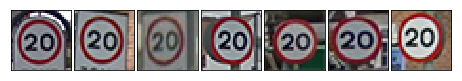

--------------------------------------------------------------------------------------

Class  11 : Right-of-way at the next intersection


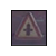

--------------------------------------------------------------------------------------

Class  13 : Yield


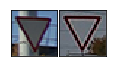

--------------------------------------------------------------------------------------

Class  17 : No entry


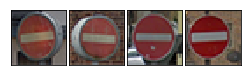

--------------------------------------------------------------------------------------

Class  21 : Double curve


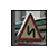

--------------------------------------------------------------------------------------

Class  24 : Road narrows on the right


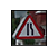

--------------------------------------------------------------------------------------

Class  28 : Children crossing


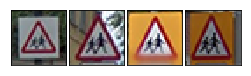

--------------------------------------------------------------------------------------

Class  32 : End of all speed and passing limits


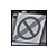

--------------------------------------------------------------------------------------

Class  34 : Turn left ahead


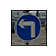

--------------------------------------------------------------------------------------

Class  38 : Keep right


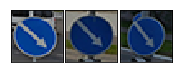

--------------------------------------------------------------------------------------

Class  39 : Keep left


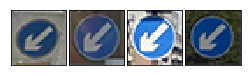

--------------------------------------------------------------------------------------

Class  40 : Roundabout mandatory


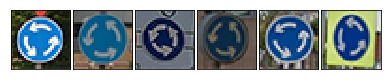

--------------------------------------------------------------------------------------

Class  99 : UNKNOWN


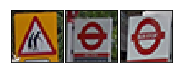

--------------------------------------------------------------------------------------



In [20]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

signnames = read_csv("signnames.csv").values[:, 1]

# Provide labels of the captured images:
y_new = np.array([
    21, # "example_00001"
    39, # "example_00002"
    17, # "example_00003"
    17, # "example_00004"
    17, # "example_00005"
    39, # "example_00006"
    39, # "example_00007"
    40, # "example_00008"
    40, # "example_00009"
    34, # "example_00010"
    28, # "example_00011"
    39, # "example_00012"
    0, # "example_00013"
    17, # "example_00014"
    38, # "example_00015"
    13, # "example_00016"
    40, # "example_00017"
    13, # "example_00018"
    38, # "example_00019"
    38, # "example_00020"
    11, # "example_00021"
    0, # "example_00022"
    28, # "example_00023"
    0, # "example_00024"
    99, # "example_00025"
    99, # "example_00026"
    99, # "example_00027"
    32, # "example_00028"
    40, # "example_00029"
    28, # "example_00030"
    40, # "example_00031"
    40, # "example_00032"
    28, # "example_00033"
    24, # "example_00034"
    0, # "example_00035"
    0, # "example_00036"
    0, # "example_00037"
    0 # "example_00038"
])

from PIL import Image

for i in np.sort(list(set(y_new.tolist()))):
    i_new = np.sum(y_new == i)
    if i_new >0:
        idx = np.argwhere(y_new==i)
        assert idx.shape[0] == i_new
        
        class_label = "UNKNOWN"
        if i <=42:
            class_label = signnames[i]
        print("Class ",i,":",class_label)
        
        fig = plt.figure(figsize = (i_new, 1))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
       
        for ii in range(i_new):
            axis = fig.add_subplot(1, i_new+1, ii + 1, xticks=[], yticks=[])
            image = Image.open(os.getcwd() + '/test_data_from_web/' + "example_{0:0>5}".format(int(idx[ii]) + 1) + '.png')
            image.load()
            axis.imshow(image)
        plt.show()
        print("--------------------------------------------------------------------------------------\n")

### Predict the Sign Type for Each Image

In [21]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

from scipy import misc

X_new = np.empty([y_new.shape[0], 32,32,3])
for i in range(y_new.shape[0]):
    fn = os.getcwd() + '/test_data_from_web/' + "example_{0:0>5}".format(i+1) + '.png'
    arr = misc.imread(fn) 
    X_new[i] = arr[:,:,:3]
    
print('Normalizing Images...')
X_new_norm = (X_new - 128.0)/128.0
X_new_norm = normalized_image(X_new_norm)

Normalizing Images...


100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 7599.46it/s]


In [22]:
# compute logits, predicted probabilities and predictions 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    logits_new = sess.run(logits, feed_dict={x: X_new_norm,dropout: 0})
    pred_probs = sess.run(tf.nn.softmax(logits_new))
    preds = sess.run(tf.argmax(pred_probs, 1))

In [23]:
# plot images (original & preprocessed) and top 5 predicted probabilities  
def plot_one(predictions, index,print_prob=False):
    
    top5 = np.sort(predictions,axis=1)[index][-5:]
    top5_label = np.argsort(predictions,axis=1)[index][-5:]
    
    # Images
    fn = os.getcwd() + '/test_data_from_web/' + "example_{0:0>5}".format(index+1) + '.png'
    original = io.imread(fn)
    preprocessed = X_new_norm[index]
        
    # Grid
    plt.figure(figsize = (6, 2))
    gridspec.GridSpec(2, 2)
    
    # Original image
    plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
    plt.imshow(original)
    plt.axis('off')

    # Preprocessed image
    plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
    plt.imshow(preprocessed, cmap='gray')
    plt.axis('off')

    # Predictions
    plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    plt.barh(np.arange(5)+.5, top5, align='center')
    plt.yticks(np.arange(5)+.5, signnames[top5_label])
    plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    
    plt.show()
    
    if print_prob:
        ct = pd.DataFrame({'Predicted_Class': top5_label[::-1], 'Predicted_Probability': top5[::-1] } )
        ct = ct.set_index(['Predicted_Probability'])
        print(ct)

0  - Actual Class  21 [ Double curve ] - Predicted Class: 35 [ Ahead only ]


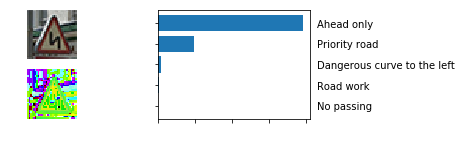

--------------------------------------------------------------------------------------

1  - Actual Class  39 [ Keep left ] - Predicted Class: 39 [ Keep left ]


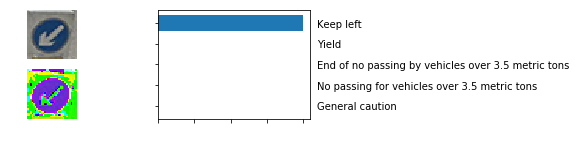

--------------------------------------------------------------------------------------

2  - Actual Class  17 [ No entry ] - Predicted Class: 17 [ No entry ]


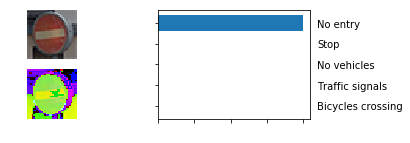

--------------------------------------------------------------------------------------

3  - Actual Class  17 [ No entry ] - Predicted Class: 17 [ No entry ]


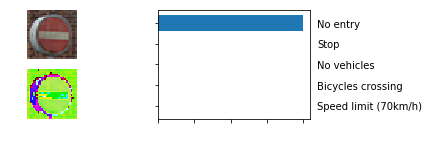

--------------------------------------------------------------------------------------

4  - Actual Class  17 [ No entry ] - Predicted Class: 17 [ No entry ]


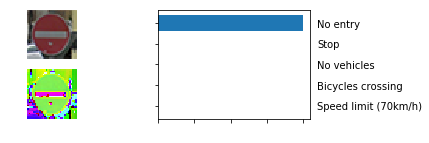

--------------------------------------------------------------------------------------

5  - Actual Class  39 [ Keep left ] - Predicted Class: 39 [ Keep left ]


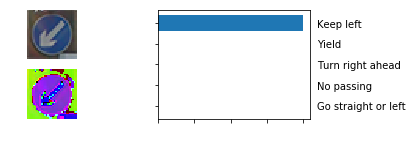

--------------------------------------------------------------------------------------

6  - Actual Class  39 [ Keep left ] - Predicted Class: 39 [ Keep left ]


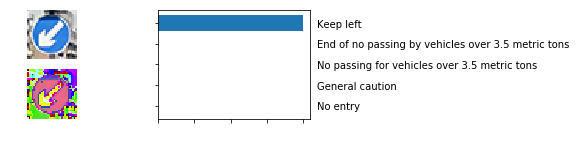

--------------------------------------------------------------------------------------

7  - Actual Class  40 [ Roundabout mandatory ] - Predicted Class: 40 [ Roundabout mandatory ]


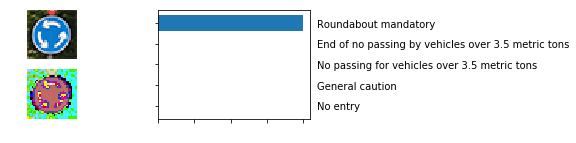

--------------------------------------------------------------------------------------

8  - Actual Class  40 [ Roundabout mandatory ] - Predicted Class: 40 [ Roundabout mandatory ]


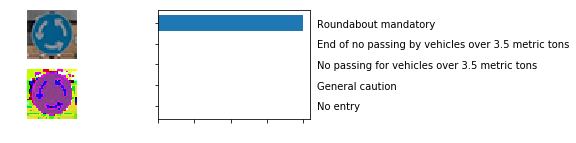

--------------------------------------------------------------------------------------

9  - Actual Class  34 [ Turn left ahead ] - Predicted Class: 34 [ Turn left ahead ]


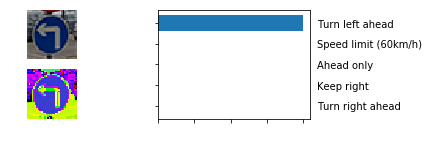

--------------------------------------------------------------------------------------

10  - Actual Class  28 [ Children crossing ] - Predicted Class: 28 [ Children crossing ]


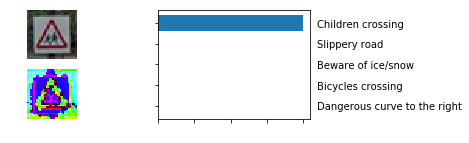

--------------------------------------------------------------------------------------

11  - Actual Class  39 [ Keep left ] - Predicted Class: 39 [ Keep left ]


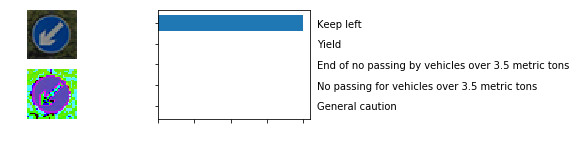

--------------------------------------------------------------------------------------

12  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 5 [ Speed limit (80km/h) ]


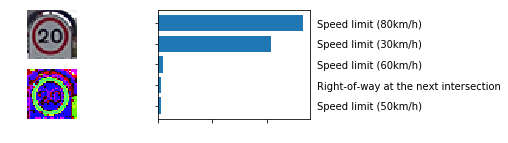

--------------------------------------------------------------------------------------

13  - Actual Class  17 [ No entry ] - Predicted Class: 17 [ No entry ]


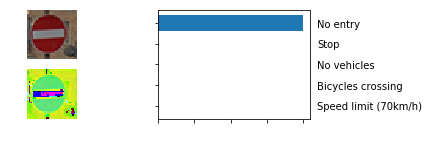

--------------------------------------------------------------------------------------

14  - Actual Class  38 [ Keep right ] - Predicted Class: 38 [ Keep right ]


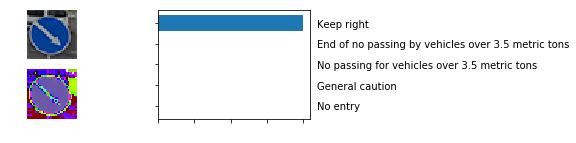

--------------------------------------------------------------------------------------

15  - Actual Class  13 [ Yield ] - Predicted Class: 13 [ Yield ]


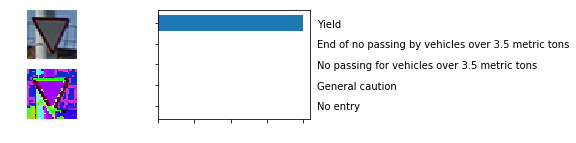

--------------------------------------------------------------------------------------

16  - Actual Class  40 [ Roundabout mandatory ] - Predicted Class: 40 [ Roundabout mandatory ]


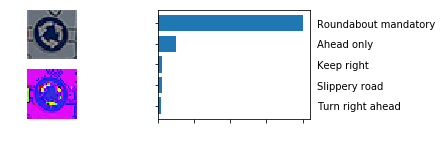

--------------------------------------------------------------------------------------

17  - Actual Class  13 [ Yield ] - Predicted Class: 13 [ Yield ]


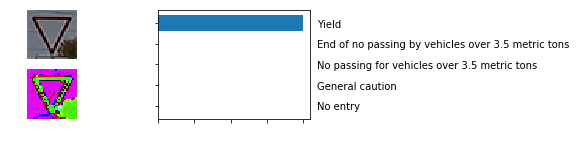

--------------------------------------------------------------------------------------

18  - Actual Class  38 [ Keep right ] - Predicted Class: 38 [ Keep right ]


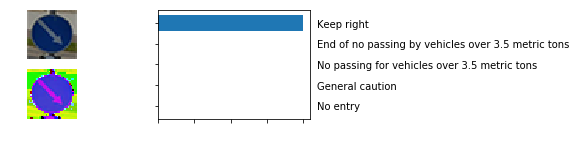

--------------------------------------------------------------------------------------

19  - Actual Class  38 [ Keep right ] - Predicted Class: 38 [ Keep right ]


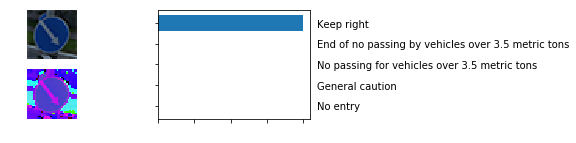

--------------------------------------------------------------------------------------

20  - Actual Class  11 [ Right-of-way at the next intersection ] - Predicted Class: 11 [ Right-of-way at the next intersection ]


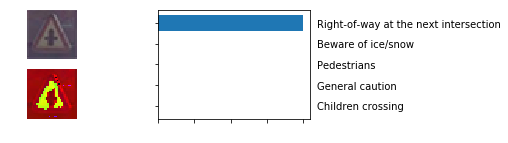

--------------------------------------------------------------------------------------

21  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 5 [ Speed limit (80km/h) ]


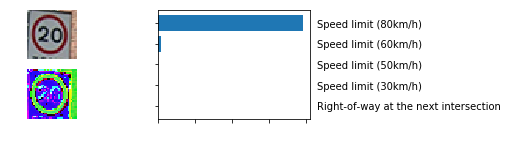

--------------------------------------------------------------------------------------

22  - Actual Class  28 [ Children crossing ] - Predicted Class: 28 [ Children crossing ]


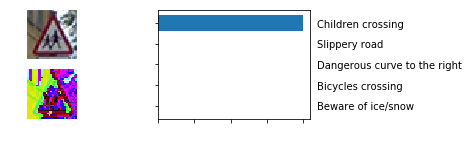

--------------------------------------------------------------------------------------

23  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 7 [ Speed limit (100km/h) ]


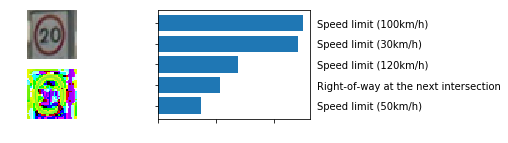

--------------------------------------------------------------------------------------

24  - Actual Class  99 [ UNKNOWN ] - Predicted Class: 20 [ Dangerous curve to the right ]


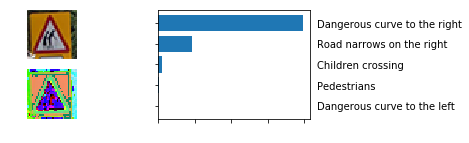

--------------------------------------------------------------------------------------

25  - Actual Class  99 [ UNKNOWN ] - Predicted Class: 13 [ Yield ]


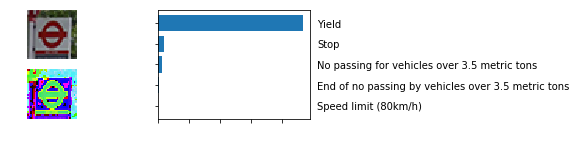

--------------------------------------------------------------------------------------

26  - Actual Class  99 [ UNKNOWN ] - Predicted Class: 7 [ Speed limit (100km/h) ]


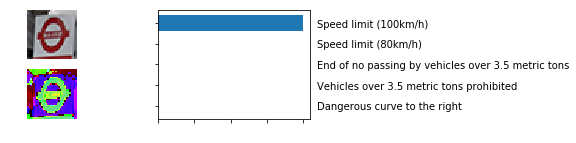

--------------------------------------------------------------------------------------

27  - Actual Class  32 [ End of all speed and passing limits ] - Predicted Class: 1 [ Speed limit (30km/h) ]


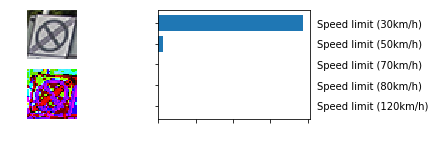

--------------------------------------------------------------------------------------

28  - Actual Class  40 [ Roundabout mandatory ] - Predicted Class: 40 [ Roundabout mandatory ]


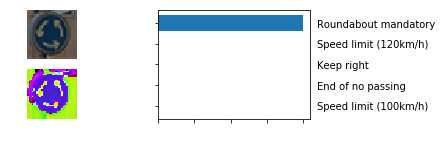

--------------------------------------------------------------------------------------

29  - Actual Class  28 [ Children crossing ] - Predicted Class: 28 [ Children crossing ]


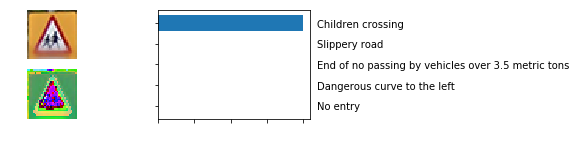

--------------------------------------------------------------------------------------

30  - Actual Class  40 [ Roundabout mandatory ] - Predicted Class: 40 [ Roundabout mandatory ]


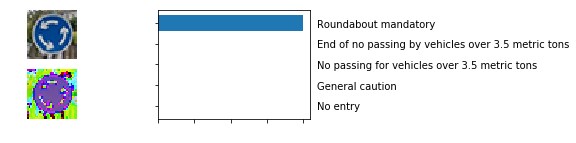

--------------------------------------------------------------------------------------

31  - Actual Class  40 [ Roundabout mandatory ] - Predicted Class: 40 [ Roundabout mandatory ]


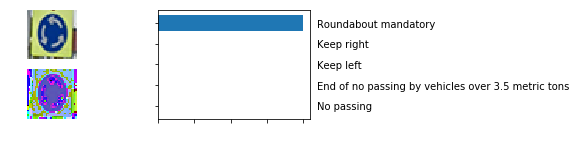

--------------------------------------------------------------------------------------

32  - Actual Class  28 [ Children crossing ] - Predicted Class: 28 [ Children crossing ]


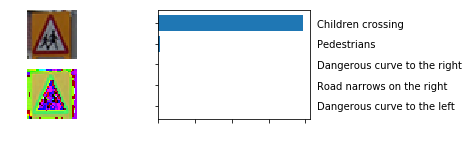

--------------------------------------------------------------------------------------

33  - Actual Class  24 [ Road narrows on the right ] - Predicted Class: 24 [ Road narrows on the right ]


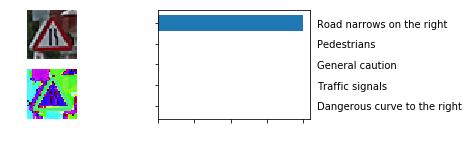

--------------------------------------------------------------------------------------

34  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 0 [ Speed limit (20km/h) ]


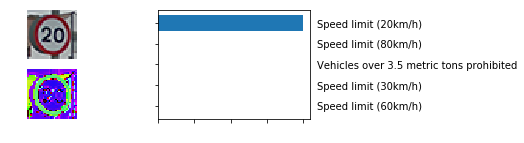

--------------------------------------------------------------------------------------

35  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 0 [ Speed limit (20km/h) ]


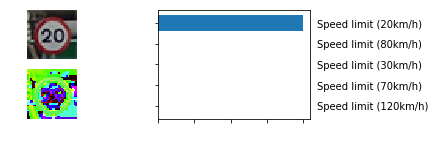

--------------------------------------------------------------------------------------

36  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 5 [ Speed limit (80km/h) ]


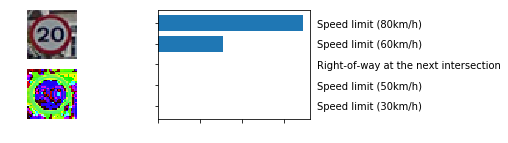

--------------------------------------------------------------------------------------

37  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 3 [ Speed limit (60km/h) ]


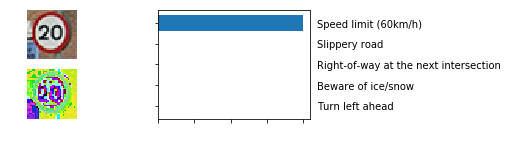

--------------------------------------------------------------------------------------



In [24]:
for i in range(y_new.shape[0]):
    correct_label = "UNKNOWN"
    if y_new[i] <= 42:
        correct_label = signnames[y_new[i]]
    print(i, " - Actual Class ",y_new[i],"[",correct_label,"] - Predicted Class:",preds[i],"[",signnames[preds[i]],"]")
    plot_one(pred_probs, i)
    print("--------------------------------------------------------------------------------------\n")

### Analyze Performance

In [25]:
### Calculate the accuracy for these > 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    ## let's remove unkwnown traffic signs (=99)
    test_new_accuracy = evaluate(X_new_norm[y_new != 99], y_new[y_new != 99])
    print("New Images Accuracy = {:.3f}".format(test_new_accuracy))

New Images Accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

0  - Actual Class  21 [ Double curve ] - Predicted Class: 35 [ Ahead only ]


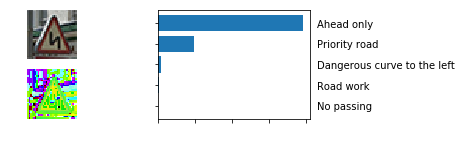

                       Predicted_Class
Predicted_Probability                 
0.783892                            35
0.196205                            12
0.013644                            19
0.005836                            25
0.000148                             9
--------------------------------------------------------------------------------------

1  - Actual Class  39 [ Keep left ] - Predicted Class: 39 [ Keep left ]


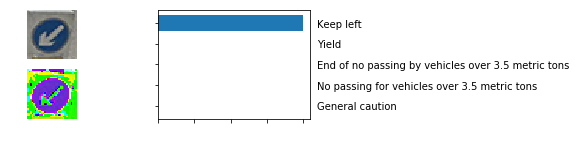

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        39
1.569842e-35                        13
0.000000e+00                        42
0.000000e+00                        10
0.000000e+00                        18
--------------------------------------------------------------------------------------

2  - Actual Class  17 [ No entry ] - Predicted Class: 17 [ No entry ]


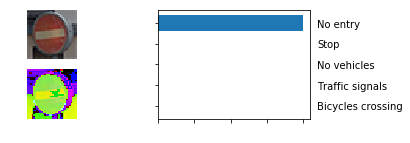

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        17
2.668292e-13                        14
2.062883e-18                        15
4.166005e-20                        26
2.733196e-20                        29
--------------------------------------------------------------------------------------

3  - Actual Class  17 [ No entry ] - Predicted Class: 17 [ No entry ]


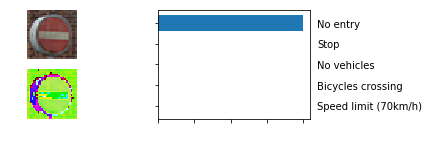

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        17
2.458582e-24                        14
2.068254e-28                        15
3.388082e-31                        29
6.815269e-32                         4
--------------------------------------------------------------------------------------

4  - Actual Class  17 [ No entry ] - Predicted Class: 17 [ No entry ]


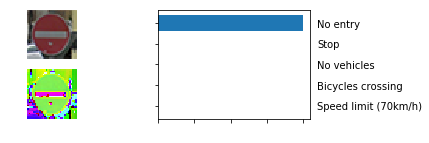

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        17
4.941180e-20                        14
1.377363e-24                        15
1.970971e-26                        29
1.265935e-27                         4
--------------------------------------------------------------------------------------

5  - Actual Class  39 [ Keep left ] - Predicted Class: 39 [ Keep left ]


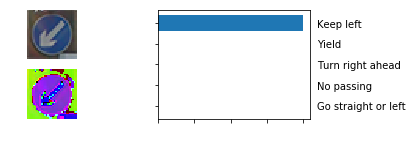

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        39
9.988885e-20                        13
3.124102e-26                        33
8.353928e-27                         9
8.848241e-28                        37
--------------------------------------------------------------------------------------

6  - Actual Class  39 [ Keep left ] - Predicted Class: 39 [ Keep left ]


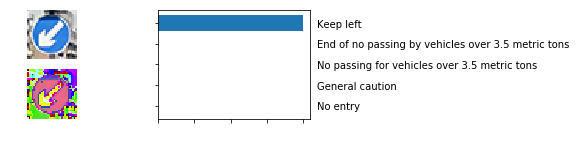

                       Predicted_Class
Predicted_Probability                 
1.0                                 39
0.0                                 42
0.0                                 10
0.0                                 18
0.0                                 17
--------------------------------------------------------------------------------------

7  - Actual Class  40 [ Roundabout mandatory ] - Predicted Class: 40 [ Roundabout mandatory ]


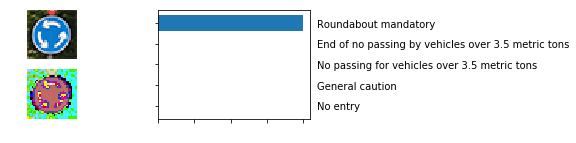

                       Predicted_Class
Predicted_Probability                 
1.0                                 40
0.0                                 42
0.0                                 10
0.0                                 18
0.0                                 17
--------------------------------------------------------------------------------------

8  - Actual Class  40 [ Roundabout mandatory ] - Predicted Class: 40 [ Roundabout mandatory ]


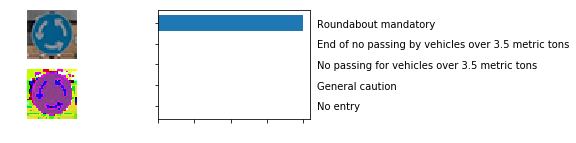

                       Predicted_Class
Predicted_Probability                 
1.0                                 40
0.0                                 42
0.0                                 10
0.0                                 18
0.0                                 17
--------------------------------------------------------------------------------------

9  - Actual Class  34 [ Turn left ahead ] - Predicted Class: 34 [ Turn left ahead ]


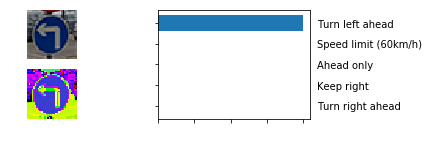

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        34
2.846906e-25                         3
4.887393e-29                        35
1.179957e-29                        38
1.256565e-31                        33
--------------------------------------------------------------------------------------

10  - Actual Class  28 [ Children crossing ] - Predicted Class: 28 [ Children crossing ]


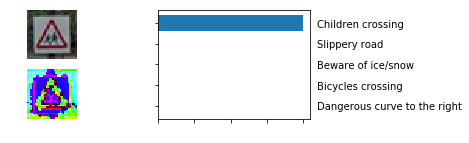

                       Predicted_Class
Predicted_Probability                 
9.999999e-01                        28
1.493507e-07                        23
5.147888e-10                        30
1.831548e-11                        29
6.393813e-16                        20
--------------------------------------------------------------------------------------

11  - Actual Class  39 [ Keep left ] - Predicted Class: 39 [ Keep left ]


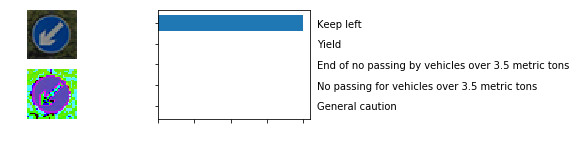

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        39
4.114262e-37                        13
0.000000e+00                        42
0.000000e+00                        10
0.000000e+00                        18
--------------------------------------------------------------------------------------

12  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 5 [ Speed limit (80km/h) ]


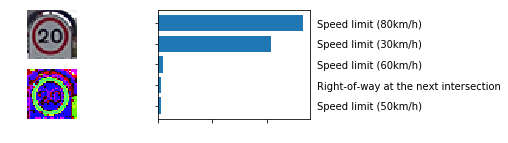

                       Predicted_Class
Predicted_Probability                 
0.533389                             5
0.414522                             1
0.016408                             3
0.012328                            11
0.011934                             2
--------------------------------------------------------------------------------------

13  - Actual Class  17 [ No entry ] - Predicted Class: 17 [ No entry ]


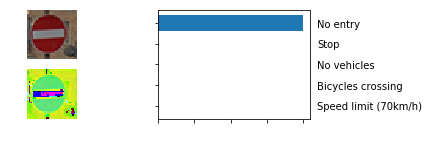

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        17
1.203084e-20                        14
9.732472e-28                        15
1.252665e-30                        29
3.365000e-31                         4
--------------------------------------------------------------------------------------

14  - Actual Class  38 [ Keep right ] - Predicted Class: 38 [ Keep right ]


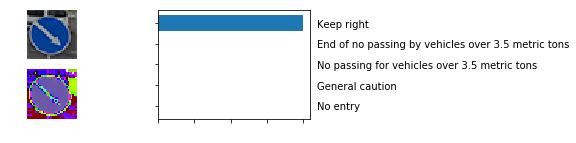

                       Predicted_Class
Predicted_Probability                 
1.0                                 38
0.0                                 42
0.0                                 10
0.0                                 18
0.0                                 17
--------------------------------------------------------------------------------------

15  - Actual Class  13 [ Yield ] - Predicted Class: 13 [ Yield ]


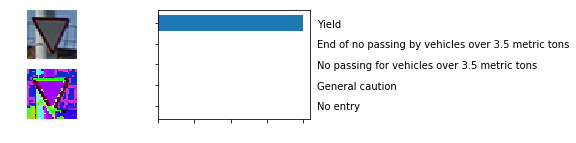

                       Predicted_Class
Predicted_Probability                 
1.0                                 13
0.0                                 42
0.0                                 10
0.0                                 18
0.0                                 17
--------------------------------------------------------------------------------------

16  - Actual Class  40 [ Roundabout mandatory ] - Predicted Class: 40 [ Roundabout mandatory ]


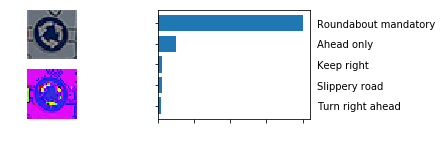

                       Predicted_Class
Predicted_Probability                 
0.802572                            40
0.100928                            35
0.023303                            38
0.019813                            23
0.015366                            33
--------------------------------------------------------------------------------------

17  - Actual Class  13 [ Yield ] - Predicted Class: 13 [ Yield ]


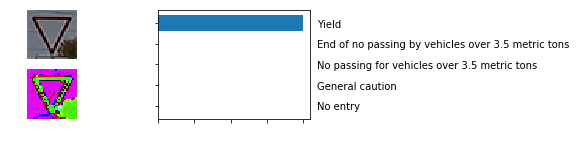

                       Predicted_Class
Predicted_Probability                 
1.0                                 13
0.0                                 42
0.0                                 10
0.0                                 18
0.0                                 17
--------------------------------------------------------------------------------------

18  - Actual Class  38 [ Keep right ] - Predicted Class: 38 [ Keep right ]


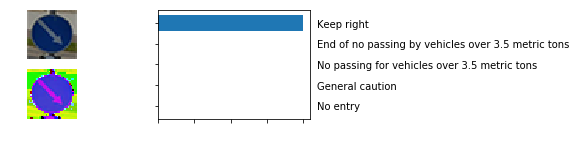

                       Predicted_Class
Predicted_Probability                 
1.0                                 38
0.0                                 42
0.0                                 10
0.0                                 18
0.0                                 17
--------------------------------------------------------------------------------------

19  - Actual Class  38 [ Keep right ] - Predicted Class: 38 [ Keep right ]


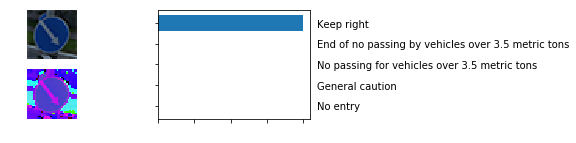

                       Predicted_Class
Predicted_Probability                 
1.0                                 38
0.0                                 42
0.0                                 10
0.0                                 18
0.0                                 17
--------------------------------------------------------------------------------------

20  - Actual Class  11 [ Right-of-way at the next intersection ] - Predicted Class: 11 [ Right-of-way at the next intersection ]


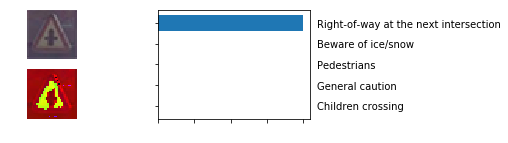

                       Predicted_Class
Predicted_Probability                 
9.999843e-01                        11
1.444965e-05                        30
1.336680e-06                        27
3.636461e-08                        18
1.994847e-10                        28
--------------------------------------------------------------------------------------

21  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 5 [ Speed limit (80km/h) ]


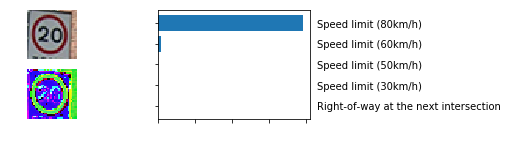

                       Predicted_Class
Predicted_Probability                 
9.820721e-01                         5
1.792746e-02                         3
5.397387e-07                         2
9.613664e-09                         1
5.811740e-09                        11
--------------------------------------------------------------------------------------

22  - Actual Class  28 [ Children crossing ] - Predicted Class: 28 [ Children crossing ]


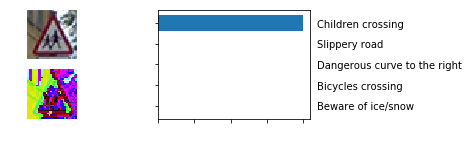

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        28
4.856412e-10                        23
1.266636e-11                        20
2.351304e-13                        29
6.123561e-14                        30
--------------------------------------------------------------------------------------

23  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 7 [ Speed limit (100km/h) ]


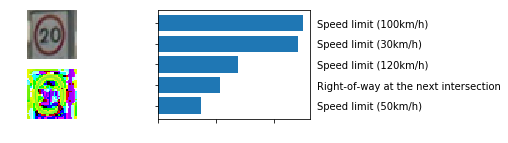

                       Predicted_Class
Predicted_Probability                 
0.250776                             7
0.242554                             1
0.138607                             8
0.106629                            11
0.074852                             2
--------------------------------------------------------------------------------------

24  - Actual Class  99 [ UNKNOWN ] - Predicted Class: 20 [ Dangerous curve to the right ]


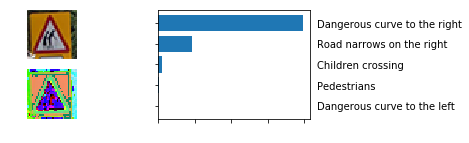

                       Predicted_Class
Predicted_Probability                 
7.927109e-01                        20
1.853355e-01                        24
1.897562e-02                        28
2.977981e-03                        27
2.386087e-12                        19
--------------------------------------------------------------------------------------

25  - Actual Class  99 [ UNKNOWN ] - Predicted Class: 13 [ Yield ]


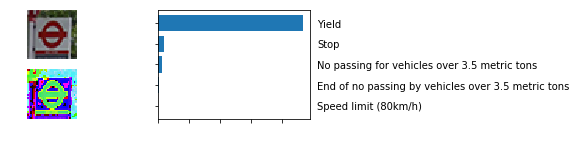

                       Predicted_Class
Predicted_Probability                 
0.933542                            13
0.037327                            14
0.025269                            10
0.003331                            42
0.000454                             5
--------------------------------------------------------------------------------------

26  - Actual Class  99 [ UNKNOWN ] - Predicted Class: 7 [ Speed limit (100km/h) ]


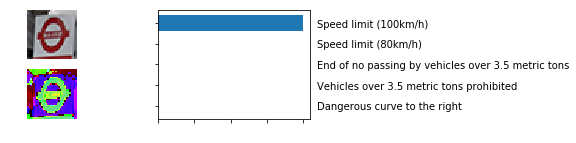

                       Predicted_Class
Predicted_Probability                 
9.999985e-01                         7
1.602565e-06                         5
9.233842e-09                        42
1.303782e-10                        16
3.991546e-11                        20
--------------------------------------------------------------------------------------

27  - Actual Class  32 [ End of all speed and passing limits ] - Predicted Class: 1 [ Speed limit (30km/h) ]


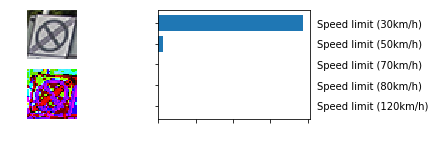

                       Predicted_Class
Predicted_Probability                 
0.967273                             1
0.032685                             2
0.000034                             4
0.000003                             5
0.000002                             8
--------------------------------------------------------------------------------------

28  - Actual Class  40 [ Roundabout mandatory ] - Predicted Class: 40 [ Roundabout mandatory ]


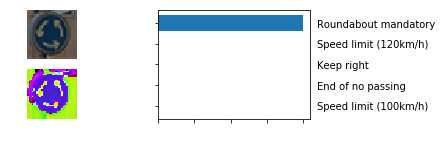

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        40
9.923300e-19                         8
1.003988e-20                        38
1.775602e-21                        41
1.125945e-21                         7
--------------------------------------------------------------------------------------

29  - Actual Class  28 [ Children crossing ] - Predicted Class: 28 [ Children crossing ]


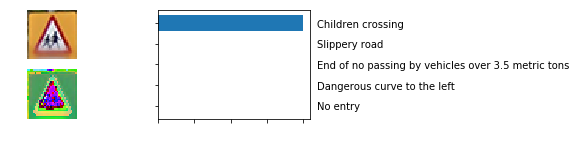

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        28
1.991766e-38                        23
0.000000e+00                        42
0.000000e+00                        19
0.000000e+00                        17
--------------------------------------------------------------------------------------

30  - Actual Class  40 [ Roundabout mandatory ] - Predicted Class: 40 [ Roundabout mandatory ]


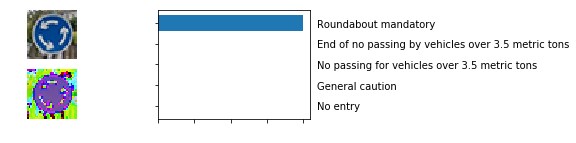

                       Predicted_Class
Predicted_Probability                 
1.0                                 40
0.0                                 42
0.0                                 10
0.0                                 18
0.0                                 17
--------------------------------------------------------------------------------------

31  - Actual Class  40 [ Roundabout mandatory ] - Predicted Class: 40 [ Roundabout mandatory ]


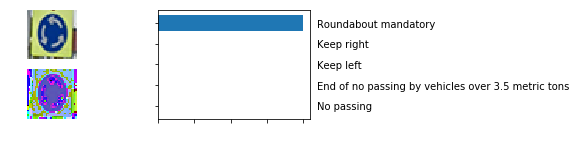

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        40
1.679565e-31                        38
1.413017e-35                        39
0.000000e+00                        42
0.000000e+00                         9
--------------------------------------------------------------------------------------

32  - Actual Class  28 [ Children crossing ] - Predicted Class: 28 [ Children crossing ]


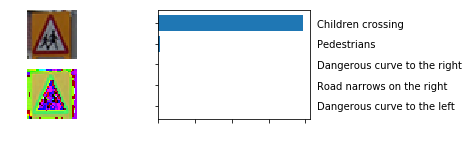

                       Predicted_Class
Predicted_Probability                 
9.841632e-01                        28
1.575740e-02                        27
4.437976e-05                        20
3.494661e-05                        24
1.143803e-07                        19
--------------------------------------------------------------------------------------

33  - Actual Class  24 [ Road narrows on the right ] - Predicted Class: 24 [ Road narrows on the right ]


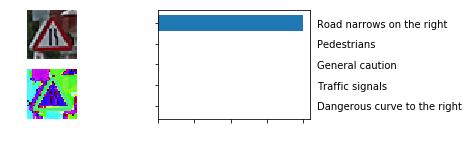

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                        24
9.776268e-13                        27
7.239410e-19                        18
3.929038e-19                        26
1.053906e-20                        20
--------------------------------------------------------------------------------------

34  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 0 [ Speed limit (20km/h) ]


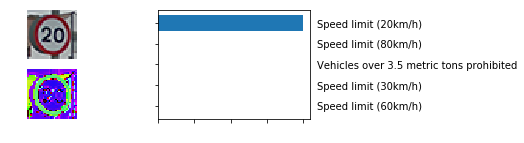

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                         0
6.810555e-20                         5
6.704343e-23                        16
1.132172e-23                         1
3.753194e-26                         3
--------------------------------------------------------------------------------------

35  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 0 [ Speed limit (20km/h) ]


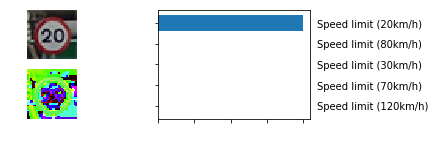

                       Predicted_Class
Predicted_Probability                 
1.000000e+00                         0
4.119970e-11                         5
3.898344e-11                         1
2.770363e-11                         4
3.288347e-13                         8
--------------------------------------------------------------------------------------

36  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 5 [ Speed limit (80km/h) ]


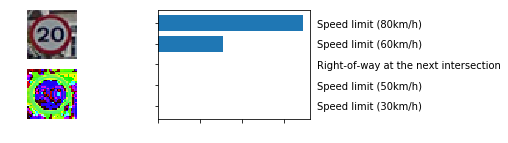

                       Predicted_Class
Predicted_Probability                 
6.914802e-01                         5
3.085185e-01                         3
6.767206e-07                        11
4.837794e-07                         2
5.013199e-08                         1
--------------------------------------------------------------------------------------

37  - Actual Class  0 [ Speed limit (20km/h) ] - Predicted Class: 3 [ Speed limit (60km/h) ]


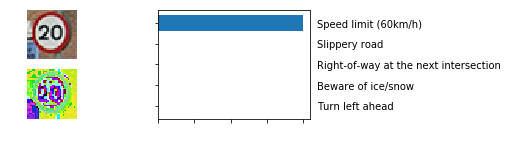

                       Predicted_Class
Predicted_Probability                 
9.970681e-01                         3
1.515712e-03                        23
1.416145e-03                        11
1.632472e-07                        30
1.583325e-08                        34
--------------------------------------------------------------------------------------



In [26]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

for i in range(y_new.shape[0]):
    correct_label = "UNKNOWN"
    if y_new[i] <= 42:
        correct_label = signnames[y_new[i]]
    print(i, " - Actual Class ",y_new[i],"[",correct_label,"] - Predicted Class:",preds[i],"[",signnames[preds[i]],"]")
    plot_one(pred_probs, i,print_prob=True)
    print("--------------------------------------------------------------------------------------\n")

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [27]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, sess, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, dropout : 0.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

0 Original Image:


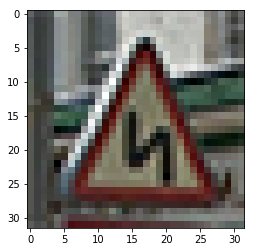

Features right after conv layer 1:


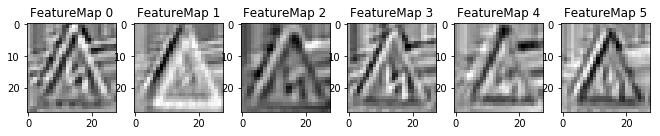

Features right after conv layer 2:


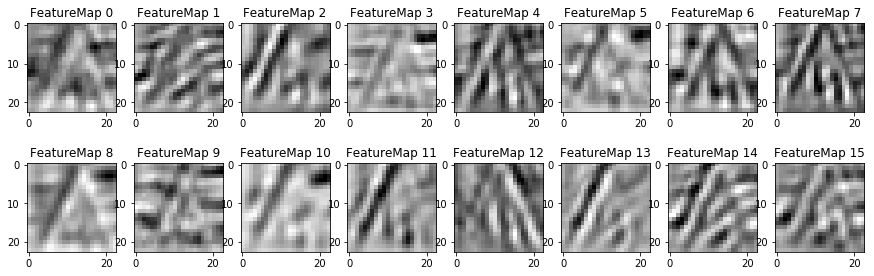

--------------------------------------------------------------------------------------

1 Original Image:


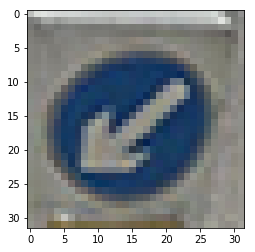

Features right after conv layer 1:


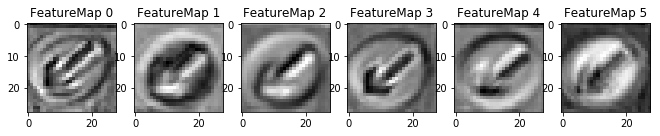

Features right after conv layer 2:


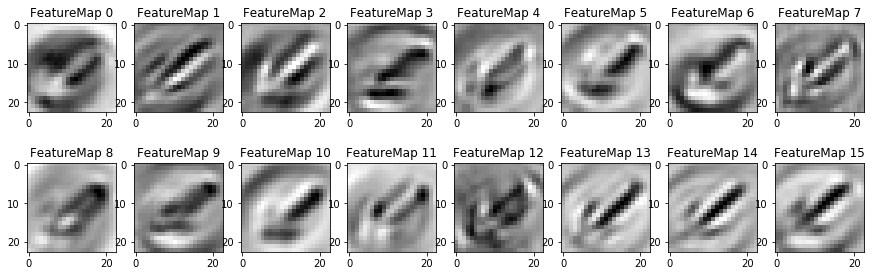

--------------------------------------------------------------------------------------

2 Original Image:


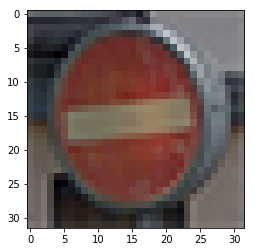

Features right after conv layer 1:


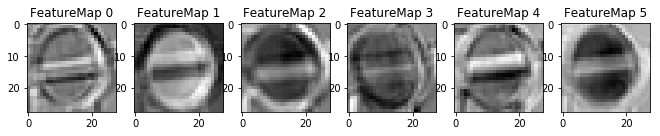

Features right after conv layer 2:


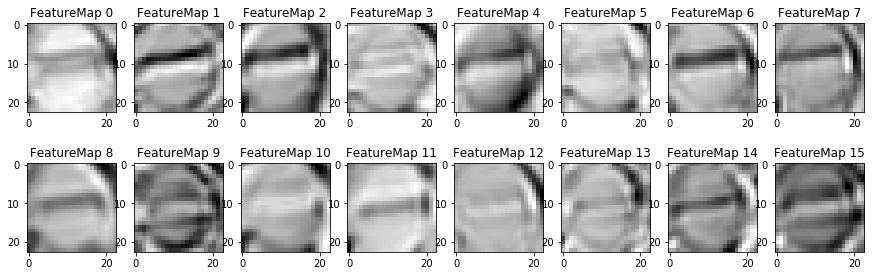

--------------------------------------------------------------------------------------

3 Original Image:


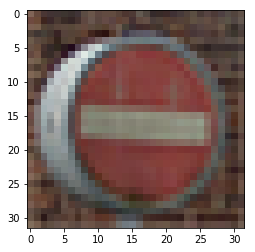

Features right after conv layer 1:


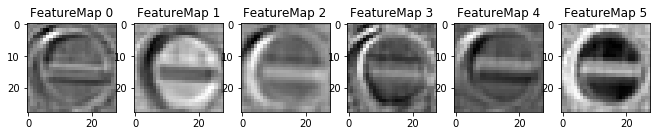

Features right after conv layer 2:


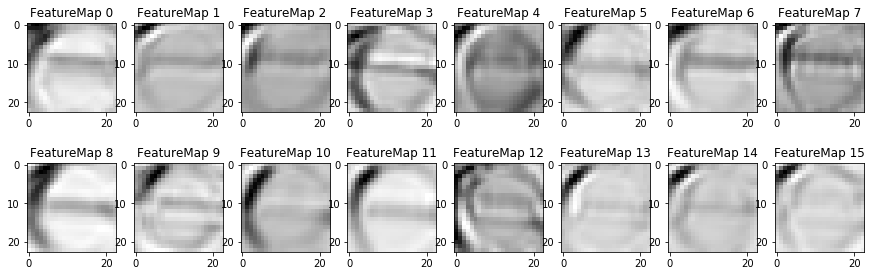

--------------------------------------------------------------------------------------

4 Original Image:


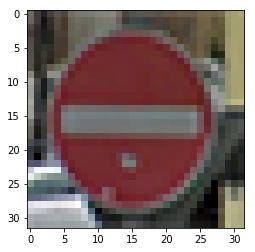

Features right after conv layer 1:


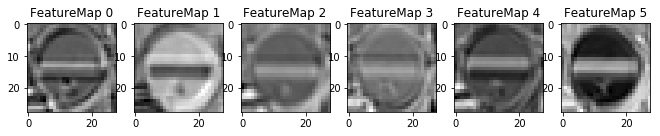

Features right after conv layer 2:


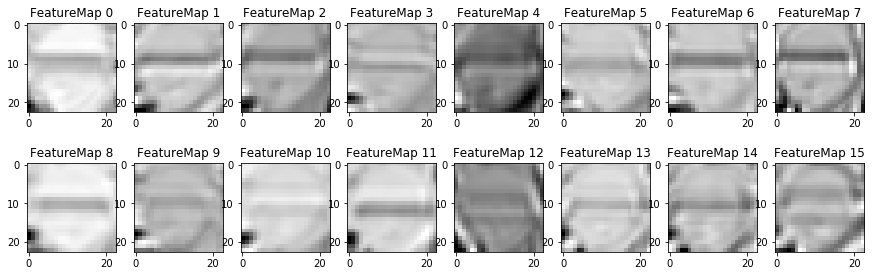

--------------------------------------------------------------------------------------

5 Original Image:


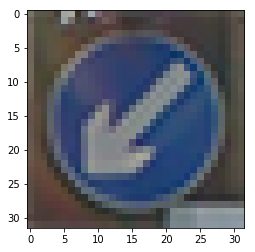

Features right after conv layer 1:


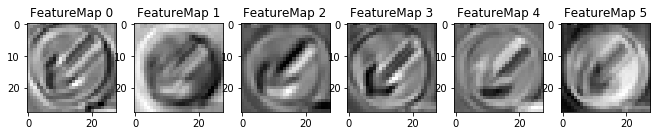

Features right after conv layer 2:


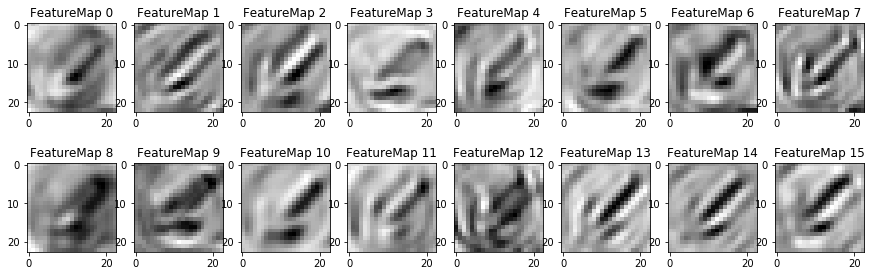

--------------------------------------------------------------------------------------

6 Original Image:


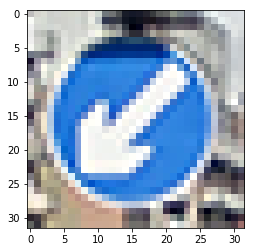

Features right after conv layer 1:


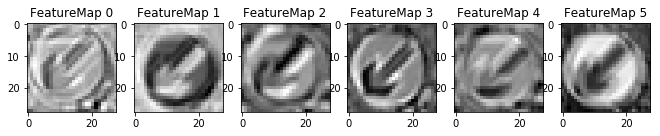

Features right after conv layer 2:


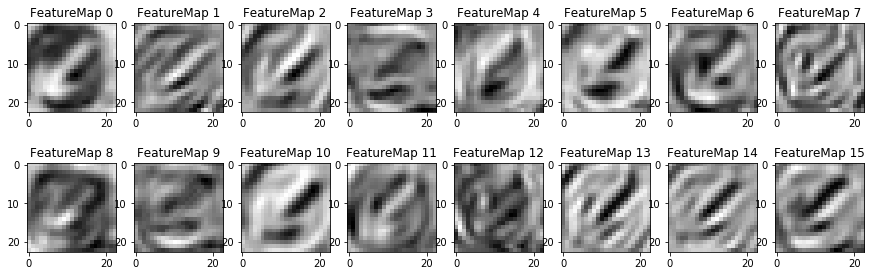

--------------------------------------------------------------------------------------

7 Original Image:


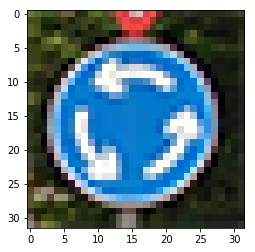

Features right after conv layer 1:


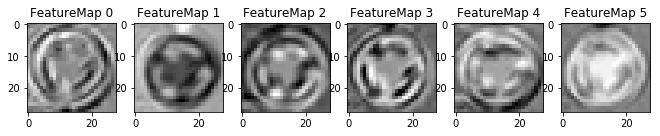

Features right after conv layer 2:


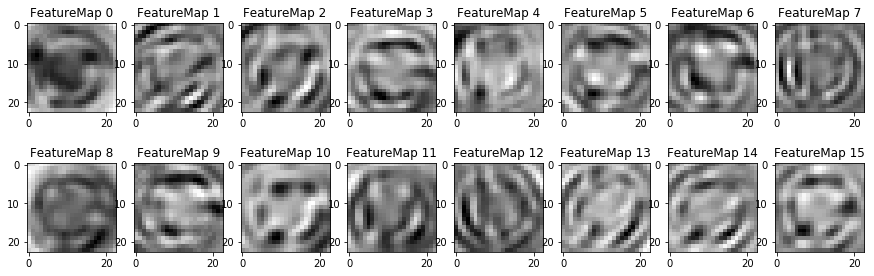

--------------------------------------------------------------------------------------

8 Original Image:


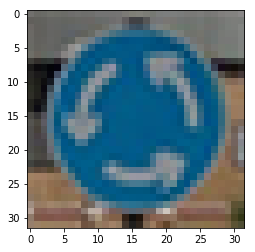

Features right after conv layer 1:


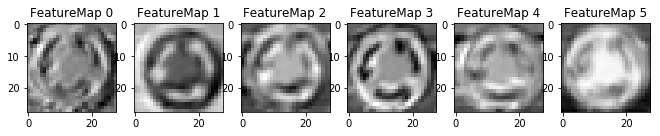

Features right after conv layer 2:


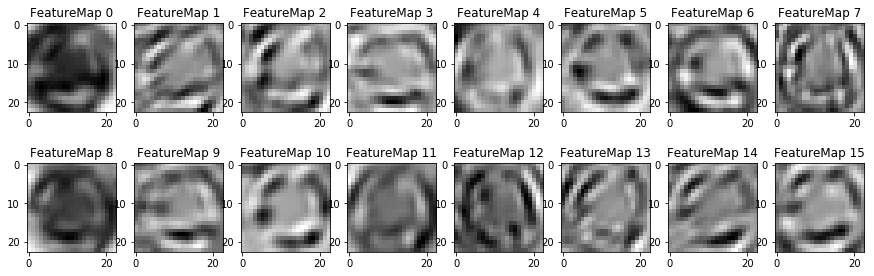

--------------------------------------------------------------------------------------

9 Original Image:


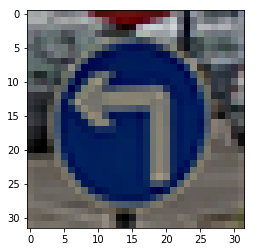

Features right after conv layer 1:


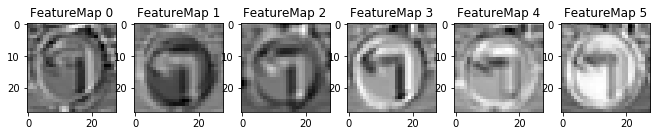

Features right after conv layer 2:


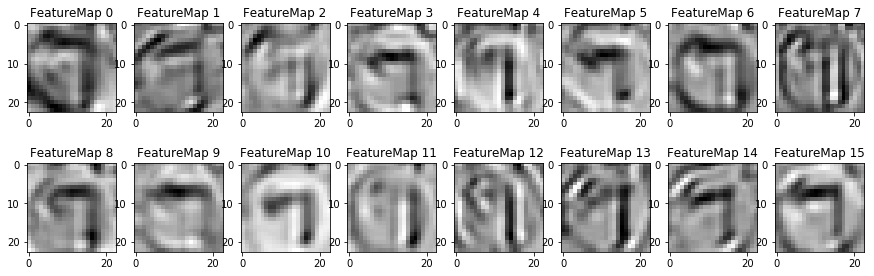

--------------------------------------------------------------------------------------



In [28]:
import matplotlib.image as mpimg

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))    
    fig = plt.figure(figsize=(32,32))
    
    for index in range(10):
        # Images
        fn = os.getcwd() + '/test_data_from_web/' + "example_{0:0>5}".format(index+1) + '.png'
        original = io.imread(fn)
        preprocessed = X_new_norm[index]
        preprocessed = preprocessed.reshape((1, 32,32,3))
        f,ax  = plt.subplots()
        print(index, "Original Image:")
        ax.imshow(original,interpolation="nearest")            
        plt.show()
            
        print("Features right after conv layer 1:")
        outputFeatureMap(preprocessed,conv1_before,sess)
        plt.show()
            
        print("Features right after conv layer 2:")
        outputFeatureMap(preprocessed,conv2_before,sess)
        plt.show()
        print("--------------------------------------------------------------------------------------\n")